<a href="https://colab.research.google.com/github/erick-arango/Proyecto_Introduccion_IA/blob/main/99_modelo_soluci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ============================================================
# 04 - Modelo alternativo: Preprocesado + Random Forest
# Competencia: UDEA AI4ENG 2025-2
# Autor: Erick Arango
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

pd.set_option("display.max_columns", None)

print("Notebook cargado correctamente.")


Notebook cargado correctamente.


In [3]:
# ============================================================
# 1. Cargar dataset limpio
# ============================================================

train = pd.read_csv("train_clean.csv")
print("train_clean.csv cargado. Shape:", train.shape)

train.head()


train_clean.csv cargado. Shape: (692500, 70)


,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4,E_VALORMATRICULAUNIVERSIDAD_num,E_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 millones,E_VALORMATRICULAUNIVERSIDAD_Entre 2.5 millones y menos de 4 millones,E_VALORMATRICULAUNIVERSIDAD_Entre 4 millones y menos de 5.5 millones,E_VALORMATRICULAUNIVERSIDAD_Entre 5.5 millones y menos de 7 millones,E_VALORMATRICULAUNIVERSIDAD_Entre 500 mil y menos de 1 millón,E_VALORMATRICULAUNIVERSIDAD_Menos de 500 mil,E_VALORMATRICULAUNIVERSIDAD_Más de 7 millones,E_VALORMATRICULAUNIVERSIDAD_No pagó matrícula,E_VALORMATRICULAUNIVERSIDAD_no info,E_HORASSEMANATRABAJA_0,E_HORASSEMANATRABAJA_Entre 11 y 20 horas,E_HORASSEMANATRABAJA_Entre 21 y 30 horas,E_HORASSEMANATRABAJA_Menos de 10 horas,E_HORASSEMANATRABAJA_Más de 30 horas,F_ESTRATOVIVIENDA_Estrato 1,F_ESTRATOVIVIENDA_Estrato 2,F_ESTRATOVIVIENDA_Estrato 3,F_ESTRATOVIVIENDA_Estrato 4,F_ESTRATOVIVIENDA_Estrato 5,F_ESTRATOVIVIENDA_Estrato 6,F_ESTRATOVIVIENDA_Sin Estrato,F_TIENEINTERNET_No,F_TIENEINTERNET_Si,F_EDUCACIONPADRE_Educación profesional completa,F_EDUCACIONPADRE_Educación profesional incompleta,F_EDUCACIONPADRE_Ninguno,F_EDUCACIONPADRE_Postgrado,F_EDUCACIONPADRE_Primaria completa,F_EDUCACIONPADRE_Primaria incompleta,F_EDUCACIONPADRE_Secundaria (Bachillerato) completa,F_EDUCACIONPADRE_Secundaria (Bachillerato) incompleta,F_EDUCACIONPADRE_Técnica o tecnológica completa,F_EDUCACIONPADRE_Técnica o tecnológica incompleta,F_EDUCACIONPADRE_no info,F_TIENELAVADORA_No,F_TIENELAVADORA_Si,F_TIENEAUTOMOVIL_No,F_TIENEAUTOMOVIL_Si,E_PRIVADO_LIBERTAD_N,E_PRIVADO_LIBERTAD_S,E_PAGOMATRICULAPROPIO_No,E_PAGOMATRICULAPROPIO_Si,F_TIENECOMPUTADOR_No,F_TIENECOMPUTADOR_Si,F_TIENEINTERNET.1_No,F_TIENEINTERNET.1_Si,F_EDUCACIONMADRE_Educación profesional completa,F_EDUCACIONMADRE_Educación profesional incompleta,F_EDUCACIONMADRE_Ninguno,F_EDUCACIONMADRE_Postgrado,F_EDUCACIONMADRE_Primaria completa,F_EDUCACIONMADRE_Primaria incompleta,F_EDUCACIONMADRE_Secundaria (Bachillerato) completa,F_EDUCACIONMADRE_Secundaria (Bachillerato) incompleta,F_EDUCACIONMADRE_Técnica o tecnológica completa,F_EDUCACIONMADRE_Técnica o tecnológica incompleta,F_EDUCACIONMADRE_no info,RENDIMIENTO_GLOBAL_alto,RENDIMIENTO_GLOBAL_bajo,RENDIMIENTO_GLOBAL_medio-alto,RENDIMIENTO_GLOBAL_medio-bajo
0,0.914049,0.966667,0.316790,0.133333,0.490107,0.427105,0.968750,0.804217,0.828571,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.652244,0.966667,0.262936,0.100000,0.473364,0.441478,0.912500,0.795181,0.485714,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.311706,0.666667,0.864836,0.133333,0.452055,0.439425,0.953125,0.795181,0.485714,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.475446,0.400000,0.014784,0.866667,0.738204,0.353183,0.787500,0.572289,0.657143,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.999743,0.966667,0.957761,0.033333,0.480974,0.476386,0.890625,0.885542,0.485714,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
# ============================================================
# 2. Reconstruir TARGET desde columnas dummy
# ============================================================

target_cols = [
    "RENDIMIENTO_GLOBAL_alto",
    "RENDIMIENTO_GLOBAL_medio-alto",
    "RENDIMIENTO_GLOBAL_medio-bajo",
    "RENDIMIENTO_GLOBAL_bajo"
]

print("Columnas objetivo detectadas:", target_cols)

# Validar filas sin clase
missing_target = (train[target_cols].sum(axis=1) == 0).sum()
print("Filas sin clase:", missing_target)

# Mapeo ordenado
mapa = {
    "RENDIMIENTO_GLOBAL_bajo": 0,
    "RENDIMIENTO_GLOBAL_medio-bajo": 1,
    "RENDIMIENTO_GLOBAL_medio-alto": 2,
    "RENDIMIENTO_GLOBAL_alto": 3
}

train["TARGET"] = train[target_cols].idxmax(axis=1).map(mapa)

# Definir X e y
y = train["TARGET"]
X = train.drop(columns=target_cols + ["TARGET"])

print("X shape:", X.shape)
print("y shape:", y.shape)


Columnas objetivo detectadas: ['RENDIMIENTO_GLOBAL_alto', 'RENDIMIENTO_GLOBAL_medio-alto', 'RENDIMIENTO_GLOBAL_medio-bajo', 'RENDIMIENTO_GLOBAL_bajo']
Filas sin clase: 0
X shape: (692500, 66)
y shape: (692500,)


In [5]:
# ============================================================
# 3. Definir columnas numéricas y categóricas
# ============================================================

numeric_cols = ["INDICADOR_1", "INDICADOR_2", "INDICADOR_3", "INDICADOR_4"]

categorical_cols = [
    c for c in X.columns
    if c not in numeric_cols + ["ID"]
]

print("Numéricas:", numeric_cols)
print("Categóricas (ejemplo):", categorical_cols[:10])
print("Total categóricas:", len(categorical_cols))


Numéricas: ['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']
Categóricas (ejemplo): ['PERIODO_ACADEMICO', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD_num', 'E_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 millones', 'E_VALORMATRICULAUNIVERSIDAD_Entre 2.5 millones y menos de 4 millones', 'E_VALORMATRICULAUNIVERSIDAD_Entre 4 millones y menos de 5.5 millones', 'E_VALORMATRICULAUNIVERSIDAD_Entre 5.5 millones y menos de 7 millones', 'E_VALORMATRICULAUNIVERSIDAD_Entre 500 mil y menos de 1 millón', 'E_VALORMATRICULAUNIVERSIDAD_Menos de 500 mil']
Total categóricas: 61


In [6]:
# ============================================================
# 4. Pipelines de preprocesamiento
# ============================================================

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_cols),
    ("cat", cat_pipeline, categorical_cols)
])

print("Preprocesador creado.")


Preprocesador creado.


In [7]:
# ============================================
# LIMPIEZA FINAL DEL TARGET — OBLIGATORIA
# ============================================

print("Valores únicos originales del TARGET:")
print(train['TARGET'].value_counts(dropna=False))

# Convertimos todo a string y limpiamos "nan"
train['TARGET'] = (
    train['TARGET']
    .astype(str)
    .str.strip()
    .str.lower()
)

# Reemplazar strings problemáticos
map_clean = {
    "alto": "alto",
    "bajo": "bajo",
    "medio": "medio",
    "medio-alto": "medio-alto",
    "medio-bajo": "medio-bajo",
    "medio alto": "medio-alto",
    "medio bajo": "medio-bajo",
    "nan": np.nan,
    "": np.nan
}

train['TARGET'] = train['TARGET'].replace(map_clean)

print("\nValores después de limpiar:")
print(train['TARGET'].value_counts(dropna=False))

# ============================================
# ELIMINAR FILAS DONDE EL TARGET ES NaN
# ============================================
before = len(train)
train = train.dropna(subset=['TARGET'])
after = len(train)

print(f"\nFilas eliminadas por TARGET NaN: {before - after}")
print("Shape final del train:", train.shape)

# ============================================
# Ahora sí, crear X e y sin NaN
# ============================================
X = train.drop(columns=['TARGET'])
y = train['TARGET']

print("\nVerificación final: ¿quedan NaN en y?", y.isna().sum())


Valores únicos originales del TARGET:
TARGET
3    175619
0    172987
1    172275
2    171619
Name: count, dtype: int64

Valores después de limpiar:
TARGET
3    175619
0    172987
1    172275
2    171619
Name: count, dtype: int64

Filas eliminadas por TARGET NaN: 0
Shape final del train: (692500, 71)

Verificación final: ¿quedan NaN en y? 0


In [8]:
# ============================================================
# 5. Train-test split
# ============================================================

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)


Train: (554000, 70)
Val: (138500, 70)


In [9]:
# ============================================================
# 6. Ajustar preprocesador y transformar datos
# ============================================================

preprocessor.fit(X_train)

X_train_enc = preprocessor.transform(X_train)
X_val_enc = preprocessor.transform(X_val)

# Obtener nombres de columnas después del one-hot
feature_names = (
    numeric_cols +
    list(preprocessor.named_transformers_["cat"]
         .named_steps["onehot"]
         .get_feature_names_out(categorical_cols))
)

print("Preprocesamiento completado.")
print("Columnas finales:", len(feature_names))


Preprocesamiento completado.
Columnas finales: 1112


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pandas as pd

# ==========================
# 1. Detectar columnas
# ==========================
categorical_cols = X_train.select_dtypes(include="object").columns.tolist()
numeric_cols = X_train.select_dtypes(exclude="object").columns.tolist()

# ==========================
# 2. Preprocessor optimizado
# ==========================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False, max_categories=20), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ],
    remainder="drop"
)

# ==========================
# 3. Modelo Random Forest optimizado
# ==========================
rf = RandomForestClassifier(
    n_estimators=120,
    max_depth=16,
    min_samples_leaf=5,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

# ==========================
# 4. Pipeline final
# ==========================
model = Pipeline([
    ("preprocess", preprocessor),
    ("rf", rf)
])

# ==========================
# 5. ENTRENAR (rápido)
# ==========================
print("Entrenando Random Forest optimizado...")
model.fit(X_train, y_train)
print("✔ Modelo entrenado.")

# ==========================
# 6. Validación
# ==========================
preds_val = model.predict(X_val)
print("\nReporte en Validación:")
print(classification_report(y_val, preds_val))


Entrenando Random Forest optimizado...
✔ Modelo entrenado.

Reporte en Validación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34597
           1       1.00      1.00      1.00     34455
           2       1.00      1.00      1.00     34324
           3       1.00      1.00      1.00     35124

    accuracy                           1.00    138500
   macro avg       1.00      1.00      1.00    138500
weighted avg       1.00      1.00      1.00    138500



Accuracy en validación: 0.38244274809160306


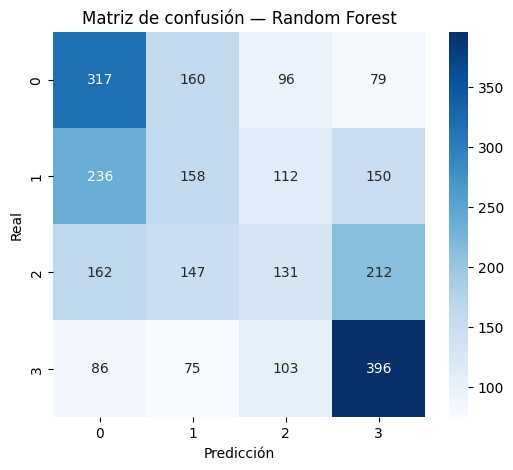

In [14]:
# ============================================================
# 8. Validación
# ============================================================

preds = rf.predict(X_val_enc)
acc = accuracy_score(y_val, preds)

print("Accuracy en validación:", acc)

# Matriz de confusión
cm = confusion_matrix(y_val, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión — Random Forest")
plt.show()


In [15]:
# ============================================================
# 9. Entrenar modelo FINAL (todo el train)
# ============================================================

preprocessor.fit(X)  # rehacer para todo el train
X_full_enc = preprocessor.transform(X)

rf_final = RandomForestClassifier(
    n_estimators=150,
    max_depth=18,
    min_samples_split=10,
    n_jobs=-1,
    random_state=42
)

print("Entrenando modelo FINAL...")
rf_final.fit(X_full_enc, y)
print("Modelo final entrenado.")


Entrenando modelo FINAL...
Modelo final entrenado.


In [16]:
# ============================================================
# 10. Cargar test_clean.csv
# ============================================================

test = pd.read_csv("test_clean.csv")
print("test_clean.csv cargado. Shape:", test.shape)


test_clean.csv cargado. Shape: (238001, 70)


In [17]:
# ============================================================
# 11. Alinear columnas de test
# ============================================================

test = test[X.columns]  # mismas columnas que X
print("Test alineado. Shape:", test.shape)


Test alineado. Shape: (238001, 70)


In [20]:
# ============================================================
# 6. Generación de submission para Kaggle
# ============================================================

print("Generando predicciones para test...")

# Transformar test final con el preprocesador YA entrenado
test_enc = preprocessor.transform(test)

# Predicciones del modelo entrenado
preds_test = rf_final.predict(test_enc)

# Convertir a enteros para evitar errores de mapeo
preds_test_int = preds_test.astype(float).astype(int)

# Diccionario de mapeo según tu orden
inv = {
    0: "bajo",
    1: "medio-bajo",
    2: "medio-alto",
    3: "alto"
}

# Convertir las predicciones numéricas a etiquetas
preds_text = [inv[p] for p in preds_test_int]

# Crear archivo final
submission = pd.DataFrame({
    "ID": test["ID"],
    "RENDIMIENTO_GLOBAL": preds_text
})

submission.to_csv("submission_rf.csv", index=False)
print("¡Archivo submission_rf.csv generado correctamente!")


Generando predicciones para test...
¡Archivo submission_rf.csv generado correctamente!


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# =====================================================
# 1. Cargar datos
# =====================================================
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train:", train.shape)
print("Test:", test.shape)

# =====================================================
# 2. Separar X y y
# =====================================================
y = train["RENDIMIENTO_GLOBAL"]
X = train.drop(columns=["RENDIMIENTO_GLOBAL"])

X_test = test.copy()

# =====================================================
# 3. Identificar columnas
# =====================================================
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

# =====================================================
# 4. Preprocesador
# =====================================================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

# =====================================================
# 5. Modelo
# =====================================================
model = Pipeline([
    ("prep", preprocessor),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        max_depth=18,
        random_state=42,
        n_jobs=-1
    ))
])

print("Entrenando modelo...")
model.fit(X, y)

# =====================================================
# 6. Predicciones sobre test
# =====================================================
print("Generando predicciones...")
preds = model.predict(X_test)

# =====================================================
# 7. Crear archivo submission
# =====================================================
submission = pd.DataFrame({
    "ID": test["ID"],
    "RENDIMIENTO_GLOBAL": preds
})

print("Submission shape:", submission.shape)
submission.to_csv("submission_final.csv", index=False)

print("Archivo generado: submission_final.csv")
